# Import relevant libraries

* pykitti to handle the kitti dataset.
* Numpy for math computations.
* open3d to visualize 3D point clouds.

In [1]:
import pykitti
import numpy as np
import cv2
import matplotlib.pyplot as plt
import open3d as o3d

#from open3d.j_visualizer import JVisualizer
#from open3d import JVisualizer 

import os

# Loading the dataset and Calibration matrices

In [2]:
# Load the dataset giving the folder, data and sample

basedir = os.getcwd() # /home/sherlock/Documents/Kitti
date = '2011_09_26'
# Drive must coincide with the one listed in the folder
drive = '0005'

# Load the dataset
dataset = pykitti.raw(basedir, date, drive)
# Read the frame number 15 of the dataset
img = plt.imread("/home/sherlock/Documents/Kitti/2011_09_26/2011_09_26_drive_0005_sync/"
                 "image_02/data/0000000015.png")
# Read the point cloud number 15 of the dataset
Velopoints = dataset.get_velo(15) 

# Loading the calibration matrices
P_rect_20 = dataset.calib.P_rect_20 # Projection matrix  P_20 from Cam0 to Cam2 rectified
R_rect_20 = dataset.calib.R_rect_20 # Rotation matrix C_20 from Cam0 to Cam2 rectified
T_rect_20 = dataset.calib.T_cam0_velo_unrect # Transformation matrix T_cam0Velo from Velo to Cam0

# Printing the camera calibration matrices
print('The rectified projection matrix P_rect_20 is: \n')
P_rect_20 = np.matrix(P_rect_20)
print(P_rect_20, P_rect_20.shape, type(P_rect_20), '\n')

print('The rectified rotation matrix R_rect_20 is: \n')
R_rect_20 = np.matrix(R_rect_20)
print(R_rect_20, R_rect_20.shape, type(R_rect_20))

print('The transformation matrix T_rect_20 is: \n')
T_rect_20 = np.matrix(T_rect_20)
print(T_rect_20, T_rect_20.shape, type(T_rect_20))

The rectified projection matrix P_rect_20 is: 

[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]] (3, 4) <class 'numpy.matrix'> 

The rectified rotation matrix R_rect_20 is: 

[[ 9.998817e-01  1.511453e-02 -2.841595e-03  0.000000e+00]
 [-1.511724e-02  9.998853e-01 -9.338510e-04  0.000000e+00]
 [ 2.827154e-03  9.766976e-04  9.999955e-01  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]] (4, 4) <class 'numpy.matrix'>
The transformation matrix T_rect_20 is: 

[[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]] (4, 4) <class 'numpy.matrix'>


## Visualizing velodyne 3D points

The velodyne measurement provides and X, Y, Z and reflectance measurement. To work with the point cloud, the reflectance component must be deleted.

In [3]:
# Casting the 3D potins into float32
Velopoints = np.asarray(Velopoints, np.float32)

# Removing the reflectance component of the lidar measurement
Velopoints = Velopoints[:, :-1]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# visualizing the 3D point cloud
o3d.visualization.draw_geometries([pcd])
#visualizer = JVisualizer()
#visualizer.add_geometry(pcd)
#visualizer.show()

# Printing the first 10 Velopoints
# Each point is composed of X, Y, Z and Reflectance
print('The first 10 Velopoints are: \n\n', Velopoints[:10], Velopoints.shape, type(Velopoints))

The first 10 Velopoints are: 

 [[1.7386e+01 1.8000e-02 7.9700e-01]
 [1.7426e+01 7.2000e-02 7.9800e-01]
 [1.7418e+01 1.2700e-01 7.9800e-01]
 [1.7471e+01 1.8200e-01 8.0000e-01]
 [1.7563e+01 2.3900e-01 8.0300e-01]
 [2.3226e+01 3.9700e-01 9.9500e-01]
 [2.3248e+01 4.7100e-01 9.9500e-01]
 [2.3144e+01 5.0500e-01 9.9200e-01]
 [2.3216e+01 5.7900e-01 9.9400e-01]
 [2.3254e+01 6.5300e-01 9.9600e-01]] (123103, 3) <class 'numpy.ndarray'>


## Rotation and Transformation matrices 

Transformations to map the points from the velodyne to the camera 2. $\boldsymbol{p}_2 = $ are the points in the camera 2 coordinate frame.

$\boldsymbol{p}_2 = \boldsymbol{P}_{rect}^2 \boldsymbol{R}_{rect}^2 \boldsymbol{T}_{velo}^{cam} \boldsymbol{p}_{velo} $

In another notation..

$\boldsymbol{p}_2 = \boldsymbol{P}_{2, Rect} \boldsymbol{R}_{Rect, 0} \boldsymbol{T}_{cam0, Velo} \boldsymbol{p}_{velo} $

Therefore:

$\boldsymbol{T}_0 = \boldsymbol{P}_{rect}^2 \boldsymbol{R}_{rect}^2 $

$\boldsymbol{T}_1 = \boldsymbol{T}_0 \boldsymbol{T}_{velo}^{cam} $

In [4]:
# Projection matrix times Rotation matrix dim(3, 4)
T0 = P_rect_20 * R_rect_20
# Transformation matrix dim(3, 4)
T1 = T0 * T_rect_20
print('The Transformation matrix from the velodyne to camera 2 is: \n\n', T1)

The Transformation matrix from the velodyne to camera 2 is: 

 [[ 6.13040929e+02 -7.18575854e+02 -2.95002805e+00 -1.24072003e+02]
 [ 1.82759005e+02  1.22395125e+01 -7.18988552e+02 -1.01607812e+02]
 [ 9.99893357e-01  4.69739411e-03  1.38291498e-02 -2.69119537e-01]]


## Filtering the Velodyne points 

De donde Johan saco el -5?

In [5]:
# x: forward, y = left and z = up
# Find the indices of every point in the cloud that has value < 5
idx = Velopoints[:,0] < 5

# Delete the point clouds where x < 5
Velopoints = np.delete(Velopoints, np.where(idx), axis = 0)

# Create a copy of the filtered Velopoints
Velopoints3P = np.copy(Velopoints)

# Save a txt file with the filtered points
np.savetxt('Raw_PointCloud_Total' + 'txt', Velopoints3P, delimiter=' ')

print('The Filtered points info is: \n\n', type(Velopoints3P), Velopoints3P.shape)

The Filtered points info is: 

 <class 'numpy.ndarray'> (36550, 3)


## Plotting the filtered Point Cloud

In [6]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# visualizing the filtered 3D point cloud
o3d.visualization.draw_geometries([pcd])

## Concatenating a column of ones to the point cloud

In [7]:
# Number of Rows in the transformation matrix
dim_M = T1.shape[0]
# Number of Columns in the transformation matrix
dim_N = T1.shape[1]

print('Rows: ', dim_M, 'Columns: ', dim_N, '\n')

if Velopoints3P.shape[1] < dim_N:
    # Create a vector of ones with the same number of Velopoints
    ones_vect_Velo3p = np.ones((Velopoints3P.shape[0], 1), int)
    # Concatenate the Vector of ones into the Velopoints matrix as an additional column
    Velopoints3P = np.concatenate((Velopoints3P, ones_vect_Velo3p), axis = 1)

# Cast the VeloPoints as a Matrix
Velopoints3P = np.matrix(Velopoints3P)
print('Velopoints3P or Velopoints3PP: \n\n', Velopoints3P[:10], Velopoints3P.shape, type(Velopoints3P))

# Copy the Velopoints
Velopoints3PP = np.copy(Velopoints3P)

Rows:  3 Columns:  4 

Velopoints3P or Velopoints3PP: 

 [[1.73859997e+01 1.79999992e-02 7.96999991e-01 1.00000000e+00]
 [1.74260006e+01 7.19999969e-02 7.97999978e-01 1.00000000e+00]
 [1.74179993e+01 1.27000004e-01 7.97999978e-01 1.00000000e+00]
 [1.74710007e+01 1.81999996e-01 8.00000012e-01 1.00000000e+00]
 [1.75629997e+01 2.38999993e-01 8.02999973e-01 1.00000000e+00]
 [2.32259998e+01 3.97000015e-01 9.95000005e-01 1.00000000e+00]
 [2.32479992e+01 4.70999986e-01 9.95000005e-01 1.00000000e+00]
 [2.31439991e+01 5.04999995e-01 9.91999984e-01 1.00000000e+00]
 [2.32159996e+01 5.78999996e-01 9.94000018e-01 1.00000000e+00]
 [2.32539997e+01 6.52999997e-01 9.95999992e-01 1.00000000e+00]] (36550, 4) <class 'numpy.matrix'>


## Transforming the point cloud

Mapping the Point Cloud from the Velodyne to Camera 2.

In [8]:
# Transpose the point cloud to be multyplied by the transformation matrix
Velopoints3P = np.transpose(Velopoints3P)
print('Velopoints3P Transposed: ', Velopoints3P.shape, '\n')

# Transform the points from the Velodyne to Camera 2
y = T1 * Velopoints3P
# Transpose again the mapped points 
y = np.transpose(y)

print('The mapped points from Velo to Cam 2 "y": \n\n', y[:10], y.shape, type(y),'\n')

Velopoints3P Transposed:  (4, 36550) 

The mapped points from Velo to Cam 2 "y": 

 [[10518.97185993  2503.02662572    17.12613244]
 [10504.6880139   2510.27910758    17.16639658]
 [10460.26119552  2509.4899662     17.15865446]
 [10453.22565879  2518.41162164    17.21193622]
 [10468.65717331  2533.76599145    17.30423471]
 [13826.20661483  3432.61827268    22.97002828]
 [13786.51852991  3437.54457722    22.9923729 ]
 [13698.33948156  3421.11074829    22.88850212]
 [13689.2982231   3433.73721114    22.96087021]
 [13659.41333001  3440.14983818    22.99924153]] (36550, 3) <class 'numpy.matrix'> 



## Map the points from the camera 2 frame to the image frame

Map the points into the image frame (x,y) homogeneous coordinates and obtain a list of indeces.

In [9]:
# Extract the X and Y coordinate of the point cloud dim_M = 3
x_y = y[:, 0:dim_M - 1]

# Create a vector of ones of size (1, 2)
b_ones = np.ones((1, dim_M-1), int)

# Extract the Z coordinates of the point cloud
z = y[:, dim_M - 1]

# Homogeneous coordinates of the camera points into image frame of camera 2
p_out = np.divide(x_y, np.multiply(z , b_ones))
print('X and Y coordinates in the image frame: \n\n', p_out[:10], p_out.shape , type(p_out), '\n')

# Obtain a list of indeces from 0 to the lenght of the VeloPoints in the image frame
idx_p_out = np.arange(start = 0, stop = p_out.shape[0], step = 1)
print('List of indeces: \n\n', idx_p_out, idx_p_out.shape , type(idx_p_out))

X and Y coordinates in the image frame: 

 [[614.20591593 146.152474  ]
 [611.93320147 146.23215167]
 [609.62013201 146.25214188]
 [607.32421515 146.31774071]
 [604.97660551 146.42462001]
 [601.92379592 149.43900943]
 [599.61268851 149.50803869]
 [598.48125525 149.46852921]
 [596.20119339 149.54734638]
 [593.90712123 149.57666465]] (36550, 2) <class 'numpy.matrix'> 

List of indeces: 

 [    0     1     2 ... 36547 36548 36549] (36550,) <class 'numpy.ndarray'>


## Plotting the points in the image

Por que las coordenadas homogeneas dan valores tan altos en X?

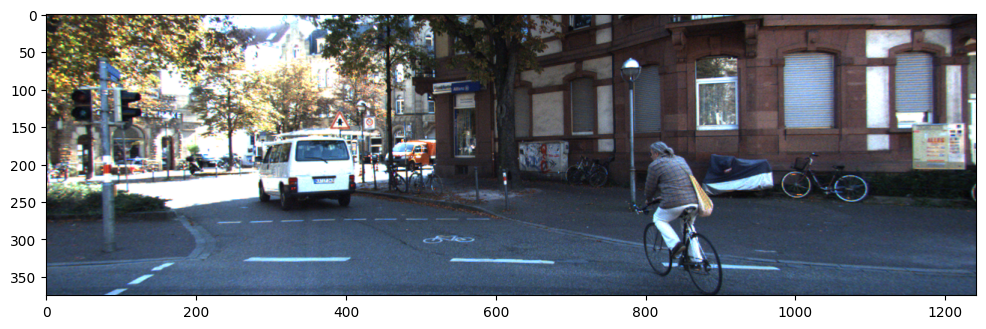

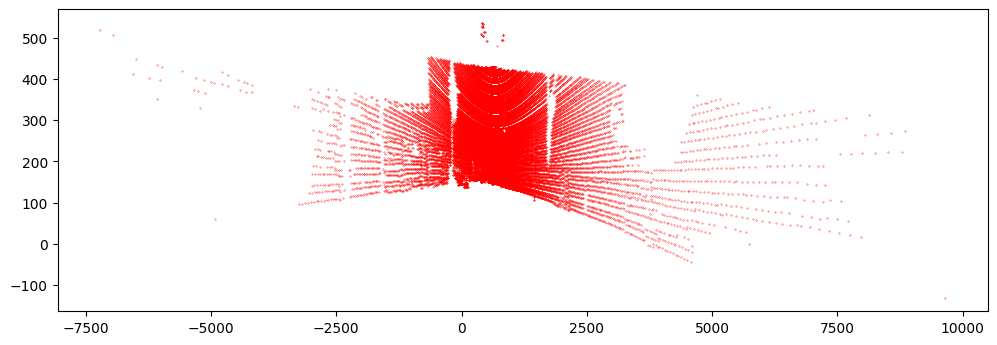

In [10]:
# Front image
plt.figure(figsize=(12, 4), dpi=100)
plt.imshow(img)
plt.show()

# X coordinate
x = p_out[:,0]
# Y coordinate
y = p_out[:,1]

plt.figure(figsize=(12, 4), dpi=100)
plt.plot(x, y, 'r.', markersize = 0.5)

## Creating a set of images based on the 3D point cloud

In [11]:
# Image Width
img_x = img.shape[1]
# Image Height
img_y = img.shape[0]

print ('The Width of the image is:', img_x, 'The Height is:', img_y,'\n')

# Evaluation of the column x for identifying the values outside the image rank
# Find the X values outside the image's rank (list of true and false)
pointxt = np.logical_or(x < 0, x > img_x)
# Obtain the index of the values in the image rank; [0] are rows and [1] are columns.
idex = np.where(np.logical_not(pointxt))[0]
# Obtain the points within the image bounds - Filtering only in X
# Recall that p_out are the X,Y velopoints in image frame
pout_ft = p_out[idex,:]

# Extract filtered indeces of point clouds in the image frame
idx_p_outt = idx_p_out[idex]
# X coordinate of the filtered points wrt to X
xa = pout_ft[:,0]
# Y coordinate of the filtered points wrt to X
yb = pout_ft[:,1]

# Evaluation of the column Y for identifying the values outside the image rank
# Find the Y values outside the image's rank (list of true and false)
pointyt = np.logical_or(yb < 0, yb > img_y)
# Obtain the index of the values in the image rank; [0] are rows and [1] are columns.
idexy = np.where(np.logical_not(pointyt))[0]
# Obtain the points within the image bounds - Filtering wrt to X and now Y
pout_fty = pout_ft[idexy,:]

print('The filtered points wrt to X and Y "pout_fty" are: \n\n', pout_fty[:10], pout_fty.shape, '\n')
# Extract indeces of the point cloud coordinates in the image frame
idx_p_outtt = idx_p_outt[idexy]
print('The final indices "idx_p_outtt: after filtering are: \n\n', idx_p_outtt, idx_p_outtt.shape, '\n')

# X coordinate of the filtered points wrt to X and Y
xaa = pout_fty[:,0]
# Y coordinate of the filtered points wrt to X and Y
ybb = pout_fty[:,1]

# Rounding the final points and casting them to integers
pout_fty = np.matrix.round(pout_fty)
pout_fty = pout_fty.astype(int)
print('The filtered points "pout_fty_int" casted as integers are: \n\n', pout_fty[:10], pout_fty.shape, type(pout_fty))


The Width of the image is: 1242 The Height is: 375 

The filtered points wrt to X and Y "pout_fty" are: 

 [[614.20591593 146.152474  ]
 [611.93320147 146.23215167]
 [609.62013201 146.25214188]
 [607.32421515 146.31774071]
 [604.97660551 146.42462001]
 [601.92379592 149.43900943]
 [599.61268851 149.50803869]
 [598.48125525 149.46852921]
 [596.20119339 149.54734638]
 [593.90712123 149.57666465]] (20270, 2) 

The final indices "idx_p_outtt: after filtering are: 

 [    0     1     2 ... 34342 34343 34344] (20270,) 

The filtered points "pout_fty_int" casted as integers are: 

 [[614 146]
 [612 146]
 [610 146]
 [607 146]
 [605 146]
 [602 149]
 [600 150]
 [598 149]
 [596 150]
 [594 150]] (20270, 2) <class 'numpy.matrix'>


## Plotting the filtered Point cloud

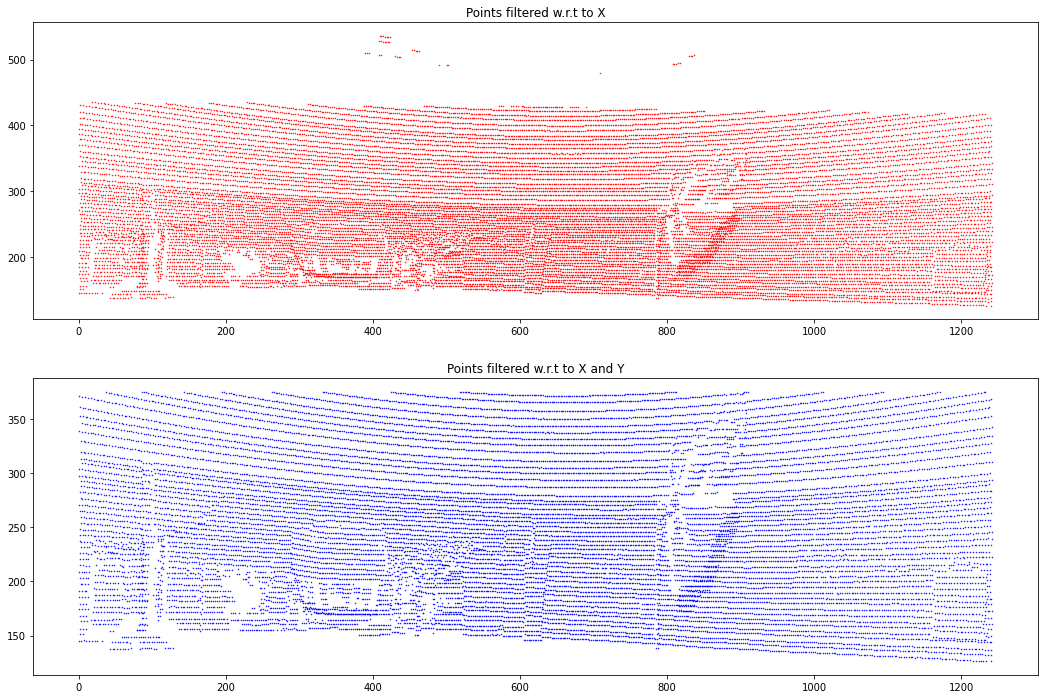

In [12]:
# Plotting the points
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(211)
ax1.title.set_text('Points filtered w.r.t to X')
ax1.plot(xa, yb, 'r.', markersize = 1)

ax2 = fig.add_subplot(212)
ax2.title.set_text('Points filtered w.r.t to X and Y')
ax2.plot(xaa, ybb, 'b.', markersize = 1)

## Aligning the Point cloud with the base image

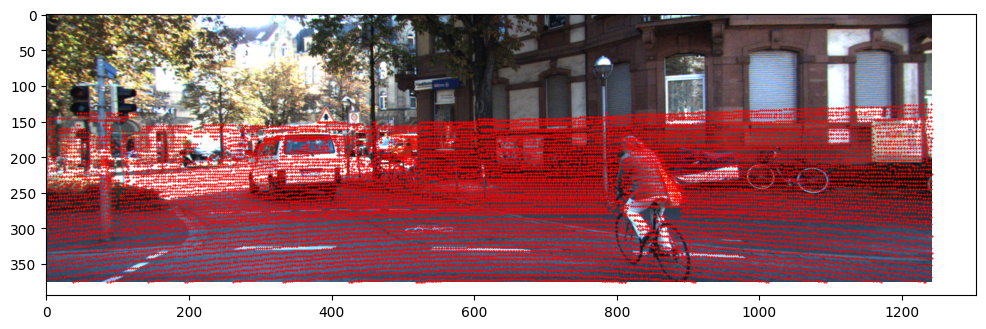

In [13]:
# Plotting the image + point cloud
plt.figure(figsize=(12, 4), dpi=100)
plt.imshow(img)
plt.plot(pout_fty[:,0], pout_fty[:,1], 'r.', markersize=1)

## Extracting the Depth of the point cloud

Los puntos no deben estar en Camera coordinates? Por que hay un -1 en matrix_points?

In [14]:
# Create an empty matrix with the shape of image size
matrix_points = np.zeros((img.shape[0], img.shape[1]))
print('The depth matrix shape is: ', matrix_points.shape)

for i in range(0, pout_fty.shape[0]):
    # Filtered X image coordinate
    x = pout_fty[i,0] 
    # Filtered Y image coordinate
    y = pout_fty[i,1]
    
    # Extract the X, Y and Z coordinate of the point cloud in Velo coordinate frame
    ppoints = Velopoints3PP[idx_p_outtt[i], 0:3]
    # Compute the euclidian distance (Depth) of every point in the image frame 
    matrix_points[y - 1, x - 1] = np.sqrt(np.power(ppoints[0], 2) + np.power( ppoints[1], 2) + 
                                          np.power(ppoints[2], 2))

#np.savetxt('Data_set_pointcloud'+'.csv', matrix_points, delimiter=',')
print('Depth Matrix with points', matrix_points.shape)

The depth matrix shape is:  (375, 1242)
Depth Matrix with points (375, 1242)


## Reflectance?

In [15]:
#Reflectancia r
Velopoints3PP[:,0:1]

array([[17.38599968],
       [17.4260006 ],
       [17.41799927],
       ...,
       [19.8560009 ],
       [20.00099945],
       [19.78899956]])

## Plotting the depth points in the image

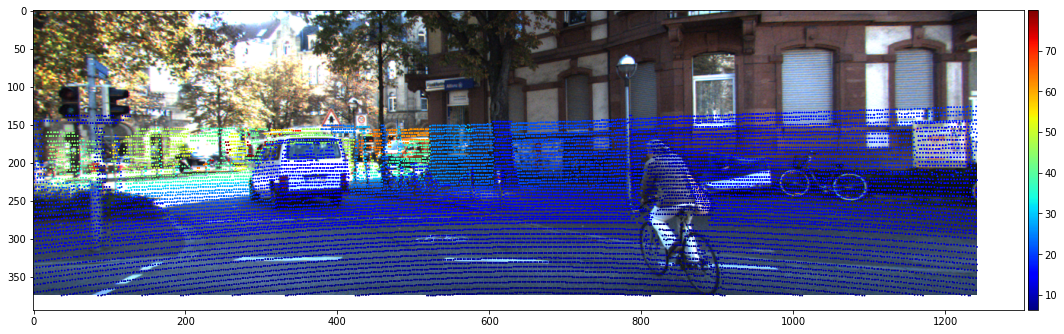

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Configuring image
fig, ax = plt.subplots()
imgplot = ax.imshow(img)
fig.set_size_inches(18, 12)

# Transforming X coordinates to list
c = pout_fty[:,0].tolist()
# Transforming Y coordiantes to list
d = pout_fty[:,1].tolist()
# X, Y and Z velopoints 
f = Velopoints3PP[:, 0:3]
# Extracting filtered points of velodyne
f = f[idx_p_outtt]   
# Computing the depth of the filtered given points
f = np.sqrt(np.power(f[:,0], 2)+ np.power(f[:,1], 2) + np.power(f[:,2], 2))
# Filtered points to list
f = f.tolist()

# Plotting
image_new = img
img = ax.scatter(c, d, s = 3, marker = ".", c = f, cmap = plt.cm.jet)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.colorbar(img, cax = cax)

plt.show()